In [3]:
import os
# from netCDF4 import Dataset
import numpy as np
import pandas as pd
import xarray as xr
from scipy import signal
import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import BoundaryNorm, LogNorm
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator

import LidarT_visualization
from eratools import era_filter, era_cmaps

plt.style.use('latex_default.mplstyle')

In [79]:
SETTINGS_FILE = 'settings_coral.txt'
SETTINGS = {}
with open(SETTINGS_FILE, 'r') as file:
    for line in file:
        try:
            line = line.strip()
            (key, val) = line.split(": ")
            SETTINGS[key] = val
        except:
            print('The following line could not be executed: ' + line)
            print('Variable might be missing!')

# fig = LidarT_visualization.plot_LidarT(file_location=fileLocation, file_name=fileName, SETTINGS=SETTINGS, plot_content='butterworthF', fixed_timeframe=True, stats_content='nightly_mean', stats_path='', save_fig=True)


### - DATA - #
case = 2020
fileLocation = '../data-coral'
if case == 2018:
    fileNames = ["20180622-2309_T20Z900.nc"]
    timeframe = [23,12]
elif case == 2020:
    fileNames  = ["20200807-2156_T15Z900.nc", "20200808-2156_T15Z900.nc"]
    timeframe = [21,10]

measurements = []
for fileName in fileNames:
    path = os.path.join(fileLocation, fileName)
    DS = xr.open_dataset(path, decode_times=False)

    DS.coords['time'] = DS.time.values / 1000
    DS.integration_start_time.values = DS.integration_start_time.values / 1000
    DS.integration_end_time.values = DS.integration_end_time.values / 1000

    # Decode times with time offset
    unit_str = DS.time_offset.attrs['units']
    DS.attrs['reference_date'] = unit_str[14:-6]
    # Reference date is first reference
    # 'Time offset' is 'seconds' after reference date
    # Time is 'seconds' after time offset

    time_reference = datetime.datetime.strptime(DS.reference_date, '%Y-%m-%d %H:%M:%S.%f')
    time_offset = datetime.timedelta(seconds=float(DS.time_offset.values[0]))
    new_time_reference = time_reference + time_offset
    time_reference_str = datetime.datetime.strftime(new_time_reference, '%Y-%m-%d %H:%M:%S')

    DS.time.attrs['units'] = 'seconds since ' + time_reference_str
    DS.integration_start_time.attrs['units'] = 'seconds since ' + time_reference_str
    DS.integration_end_time.attrs['units'] = 'seconds since ' + time_reference_str

    DS = xr.decode_cf(DS, decode_coords = True, decode_times = True) 

    fixed_start = timeframe[0]
    fixed_end = timeframe[1]
    if fixed_end < fixed_start:
        fixed_intervall = fixed_end + 24 - fixed_start
    else: 
        fixed_intervall = fixed_end - fixed_start
        
    start_date = datetime.datetime.utcfromtimestamp(DS.time.values[0].astype('O')/1e9)
    fixed_start_date = datetime.datetime(start_date.year, start_date.month, start_date.day, fixed_start, 0,0)
    duration = datetime.datetime.utcfromtimestamp(DS.integration_end_time.values[-1].astype('O')/1e9) -  datetime.datetime.utcfromtimestamp(DS.integration_start_time.values[0].astype('O')/1e9)# for calendar

    reference_hour = 15
    if (start_date.hour > reference_hour) and (fixed_start_date.hour > reference_hour):
        DS['date_startp'] = fixed_start_date
        DS['date_endp'] = fixed_start_date + datetime.timedelta(hours=fixed_intervall)
    elif (start_date.hour > reference_hour) and (fixed_start_date.hour < reference_hour): # prob in range of 0 to 10
        DS['date_startp'] = fixed_start_date + datetime.timedelta(hours=24)
        DS['date_endp'] = fixed_start_date + datetime.timedelta(hours=24+fixed_intervall)
    elif (start_date.hour < reference_hour) and (fixed_start_date.hour > reference_hour):
        DS['date_startp'] = fixed_start_date - datetime.timedelta(hours=24)
        DS['date_endp'] = fixed_start_date - datetime.timedelta(hours=24-fixed_intervall)
    else: # (start_date.hour < 18) and (fixed_start_date.hour < 18):
        DS['date_startp'] = fixed_start_date
        DS['date_endp'] = fixed_start_date - datetime.timedelta(hours=fixed_intervall)
        
    DS['fixed_timeframe'] = 1

    # Temperature (Change 0 to NaN)
    DS.temperature.values = np.where(DS.temperature == 0, np.nan, DS.temperature)
    DS.temperature_err.values = np.where(DS.temperature_err == 0, np.nan, DS.temperature_err)

    DS['alt_plot'] = (DS.altitude + DS.altitude_offset + DS.station_height) / 1000 #km

    # DS = LidarT_visualization.butterworthf(DS)
    DS = LidarT_visualization.butterworthf(DS, highcut=1/20, fs=1/0.1, order=5, single_column_filter=True)

    tmp_mean = DS.temperature.rolling(time=30, center = True).mean(dim='time')
    DS['tmp_runningM'] = DS.temperature-tmp_mean

    tmp_mean = DS.temperature.mean(dim='time')
    DS['tmp_tfilter'] = DS.temperature-tmp_mean

    measurements.append(DS)

if case == 2020:
    measurements[1]["time"] = measurements[1].time - np.timedelta64(12, 'h')

/var/folders/5n/r616r2rx3710m3kyf90_xwdr0000gn/T/ipykernel_10408/3768563241.py:89: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  tmp_mean = DS.temperature.rolling(time=30, center = True).mean(dim='time')
/var/folders/5n/r616r2rx3710m3kyf90_xwdr0000gn/T/ipykernel_10408/3768563241.py:89: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  tmp_mean = DS.temperature.rolling(time=30, center = True).mean(dim='time')


/var/folders/5n/r616r2rx3710m3kyf90_xwdr0000gn/T/ipykernel_10408/3339102695.py:91: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(xlabels)


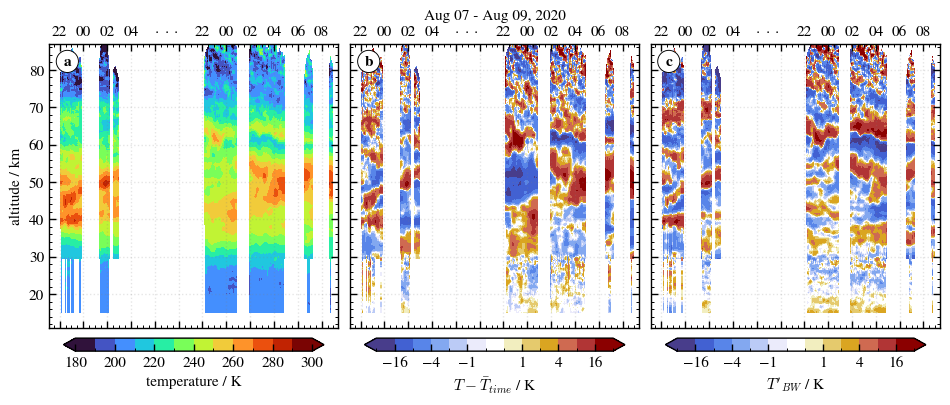

In [88]:
"""Visualize CORAL measurements (temperature + perturbations)"""
if case==2018:
    fig, axes = plt.subplots(1,3,figsize=(9,4.5), sharex=True, sharey=True, gridspec_kw={'hspace':0.15, 'wspace':0.04, 'width_ratios': [1,1,1]})
elif case == 2020:
    fig, axes = plt.subplots(1,3,figsize=(11.5,4.5), sharex=True, sharey=True, gridspec_kw={'hspace':0.15, 'wspace':0.04})
    

"""Temperature"""
clev   = np.arange(180,310,10)
cmap = plt.get_cmap('turbo') # 'jet'
norm = BoundaryNorm(boundaries=clev, ncolors=cmap.N, clip=True)

for DS in measurements:
    pcolor_0 = axes[0].pcolormesh(DS.time.values, DS.alt_plot.values, np.matrix.transpose(DS.temperature.values),
                                cmap=cmap, norm=norm)
cbar = fig.colorbar(pcolor_0, ax=axes[0],orientation='horizontal', shrink = 0.9, pad=0.03, extend='both')
cbar.set_label("temperature / K")

# - Temperature background - #
# pcolor_01 = axes[1].pcolormesh(DS.time.values, DS.alt_plot.values, np.matrix.transpose(DS.tmp_bg.values),
#                         cmap=cmap, norm=norm, shading='nearest')                      
# cbar = fig.colorbar(pcolor_01, ax=axes[1],orientation='horizontal', shrink = 0.9, pad=0.03) 
# cbar.set_label(r"$\bar{T}$ / K")

"""Temperature perturbations"""
clev_pert   = [-32,-16,-8,-4,-2,-1,-0.5,0.5,1,2,4,8,16,32] # 32
clev_l_pert = [-16,-4,-1,1,4,16]
# cmap = plt.get_cmap('RdBu_r')
cmap_pert = era_cmaps.get_wave_cmap()
norm_pert = BoundaryNorm(boundaries=clev_pert, ncolors=cmap_pert.N, clip=True)

# - Temperature temporal mean - #
for DS in measurements:
    pcolor_01 = axes[1].pcolormesh(DS.time.values, DS.alt_plot.values, np.matrix.transpose(DS.tmp_tfilter.values),
                            cmap=cmap_pert, norm=norm_pert, shading='nearest')                      
cbar = fig.colorbar(pcolor_01, ax=axes[1],orientation='horizontal', ticks=clev_l_pert, shrink = 0.9, pad=0.03, extend='both') 
cbar.set_label(r"$T-\bar{T}_{time}$ / K")

# - Temperature BW filter - #
for DS in measurements:
        pcolor_1 = axes[2].pcolormesh(DS.time.values, DS.alt_plot.values, np.matrix.transpose(DS.tmp_pert.values),
                                cmap=cmap_pert, norm=norm_pert, shading='nearest')
# pcolor_1 = axes[1].pcolormesh(DS.time.values, DS.alt_plot.values, np.matrix.transpose(DS.tmp_runningM.values),
#                         cmap=cmap, norm=norm, shading='nearest')                       
cbar = fig.colorbar(pcolor_1, ax=axes[2],orientation='horizontal', ticks=clev_l_pert, shrink = 0.9, pad=0.03, extend='both') 
cbar.set_label(r"$T'_{BW}$ / K")

"""Formatting (Date range)"""
date0 = datetime.datetime.utcfromtimestamp(measurements[0].time.values[0].astype('O')/1e9)
#date1 = datetime.datetime.utcfromtimestamp(measurements[-1].time.values[-1].astype('O')/1e9)
date1 = datetime.datetime.utcfromtimestamp(measurements[-1].date_endp.values.astype('O')/1e9)
axes[1].set_xlabel(datetime.datetime.strftime(date0, '%b %d') + ' - ' + datetime.datetime.strftime(date1, '%b %d, %Y'))
# axes[1].set_xlabel(datetime.datetime.strftime(date-datetime.timedelta(days=1), '%b %d') + ' - ' + datetime.datetime.strftime(date, '%b %d, %Y'))

# - Labels - #
axes[0].set_ylim([11,87])
axes[0].set_ylabel('altitude / km')

# - XLIM - #
# if measurements[0].fixed_timeframe.values:
#     axes[0].set_xlim(measurements[0].date_startp.values,measurements[-1].date_endp.values)
if case == 2020:
    axes[0].set_xlim(measurements[0].time.values[0]-np.timedelta64(60,'m'),measurements[-1].time.values[-1]-np.timedelta64(1,'h')) 
    xpp = 0.05
elif case == 2018:
    axes[0].set_xlim(measurements[0].time.values[0]-np.timedelta64(1,'m'),measurements[-1].time.values[-1])
    xpp = 0.065
else:
    axes[0].set_xlim(measurements[0].time.values[0],measurements[-1].time.values[-1]) 

# X-Ticks
# h_fmt = mdates.DateFormatter('%H:%M')
h_fmt = mdates.DateFormatter('%H')
h_interv = mdates.HourLocator(interval = 2)
numb_str = ['a','b','c']
for i, ax in enumerate(axes):
    ax.grid()
    ax.yaxis.set_minor_locator(AutoMinorLocator()) 
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.xaxis.set_label_position('top') 
    ax.tick_params(which='both', top=True, labelbottom=False,labeltop=True)
    ax.xaxis.set_major_locator(h_interv)
    ax.xaxis.set_major_formatter(h_fmt)     

    # - Numbering - #
    ax.text(xpp, 0.925, numb_str[i], transform=ax.transAxes, weight='bold', bbox={"boxstyle" : "circle", "lw":0.67, "facecolor":"white", "edgecolor":"black"})

if case == 2020:
    xlabels = axes[0].get_xticklabels()
    xlabels[-8:] = ["      $\cdot \, \cdot \cdot$","","22","00","02","04","06","08"]
    axes[0].set_xticklabels(xlabels)

fig_path = 'output/coral_event_' + fileName[0:8] + '.png'
fig.savefig(fig_path, facecolor='w', edgecolor='w', format='png', dpi=300, bbox_inches='tight') # orientation='portrait'